<a href="https://colab.research.google.com/github/richaray/Image-Classification-with-CNN/blob/main/FlowerImageClassificationCNNipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import pathlib
import tensorflow_hub as hub
import tf_keras
from tensorflow import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore


In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 2s 0us/step


In [4]:
data_dir

'./datasets/flower_photos'

In [5]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


## Using **OpenCV** to read flower images from disk into numpy array
Images are also being resized and preprocessed

In [7]:

flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),

}

In [8]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [9]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [10]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
  for image in images:
    img = cv2.imread(str(image))
    # resized_img = cv2.resize(img,(224,224))
    x = cv2.resize(img,(224,224))
    #x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    X.append(x)
    y.append(flowers_labels_dict[flower_name])

In [11]:
X = np.array(X)
y = np.array(y)
X.shape

(3670, 224, 224, 3)



**TRAIN TEST SPLIT**


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Preprocessing : Scale Images


In [13]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Data Augmentation**

In [14]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])

 **Transfer Learning** using a pre-trained model from google's Tensorflow Hub


In [15]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [16]:
num_of_flowers = 5

model = tf.keras.Sequential([
  data_augmentation,
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

Fine Tuning Epochs

In [17]:

for i in range(6) :
  print("With total number of epochs:"+str(i))
  model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

  small_train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled[:1000], y_train[:1000])
  ).batch(32)

  model.fit(small_train_dataset, epochs=i)

With total number of epochs:0
With total number of epochs:1
32/32 [==============================] - 64s 2s/step - loss: 1.2189 - acc: 0.4940
With total number of epochs:2
Epoch 1/2
32/32 [==============================] - 48s 1s/step - loss: 0.7216 - acc: 0.7400
Epoch 2/2
32/32 [==============================] - 44s 1s/step - loss: 0.5436 - acc: 0.8090
With total number of epochs:3
Epoch 1/3
32/32 [==============================] - 43s 1s/step - loss: 0.4985 - acc: 0.8270
Epoch 2/3
32/32 [==============================] - 38s 1s/step - loss: 0.4197 - acc: 0.8490
Epoch 3/3
32/32 [==============================] - 38s 1s/step - loss: 0.3815 - acc: 0.8620
With total number of epochs:4
Epoch 1/4
32/32 [==============================] - 41s 1s/step - loss: 0.3775 - acc: 0.8610
Epoch 2/4
32/32 [==============================] - 40s 1s/step - loss: 0.3308 - acc: 0.8840
Epoch 3/4
32/32 [==============================] - 38s 1s/step - loss: 0.3072 - acc: 0.9000
Epoch 4/4
32/32 [===============

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [19]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

small_train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled[:1000], y_train[:1000])
).batch(32)
model.fit(small_train_dataset, epochs=5)

# model.fit(X_train_scaled, y_train, batch_size=16, epochs=5)

Epoch 1/5
32/32 [==============================] - 40s 1s/step - loss: 0.2420 - acc: 0.9190
Epoch 2/5
32/32 [==============================] - 37s 1s/step - loss: 0.2298 - acc: 0.9200
Epoch 3/5
32/32 [==============================] - 37s 1s/step - loss: 0.2063 - acc: 0.9320
Epoch 4/5
32/32 [==============================] - 41s 1s/step - loss: 0.1979 - acc: 0.9320
Epoch 5/5
32/32 [==============================] - 40s 1s/step - loss: 0.1891 - acc: 0.9370


## **Evaluation Metrics**

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [21]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

29/29 [==============================] - 34s 1s/step


In [22]:
def eval_metrics(y_test, y_pred_classes, flowers_labels_dict):
  conf_matrix = confusion_matrix(y_test, y_pred_classes)
  print("Confusion Matrix:\n", conf_matrix)

  class_report = classification_report(y_test, y_pred_classes, target_names=flowers_labels_dict)
  print("\nClassification Report:\n", class_report)

  accuracy = accuracy_score(y_test, y_pred_classes)
  print("\nAccuracy:", accuracy)

In [23]:
eval_metrics(y_test, y_pred_classes, flowers_labels_dict)

Confusion Matrix:
 [[149   1   1   2  23]
 [  6 126  12   3   7]
 [  2   2 209  10   3]
 [  1   4  10 120  15]
 [ 23   3   2   2 182]]

Classification Report:
               precision    recall  f1-score   support

       roses       0.82      0.85      0.83       176
       daisy       0.93      0.82      0.87       154
   dandelion       0.89      0.92      0.91       226
  sunflowers       0.88      0.80      0.84       150
      tulips       0.79      0.86      0.82       212

    accuracy                           0.86       918
   macro avg       0.86      0.85      0.85       918
weighted avg       0.86      0.86      0.86       918


Accuracy: 0.8562091503267973


# **Making Prediction**

In [24]:
def preprocessing(img):
  # plt.imshow(img)
  # resized_img = cv2.resize(img,(224,224))
  # resized_img_scaled = resized_img / 255
  # img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
  #x = tf.keras.utils.img_to_array(img)
  x = cv2.resize(img,(224,224))
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # Displaying the preprocessed and Original Image
  plt.imshow(x[0, :, :, :3])
  plt.show()
  # PIL.Image.open(img)
  return x

In [25]:
def classify(image):
  #read image
  img = cv2.imread(image)
  #pre-process image
  processed_img = preprocessing(img)
  #predicting by model
  result = model.predict(processed_img)
  return result


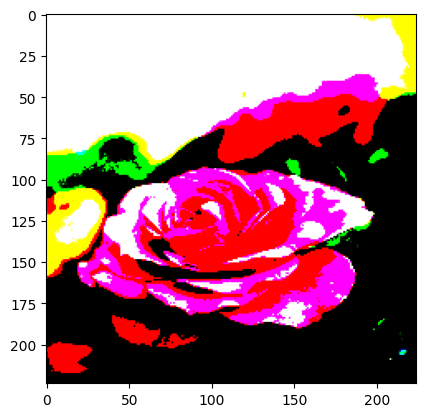

1/1 [==============================] - 0s 94ms/step
rose


In [27]:
flower_name = classify("/content/rose.jpg")
flower_name_classes = np.argmax(flower_name, axis=1)
if (flower_name_classes==0):
  print("rose")
if (flower_name_classes==1):
  print("daisy")
if (flower_name_classes==2):
  print("dandelion")
if (flower_name_classes==3):
  print("sunflower")
if (flower_name_classes==4):
  print("tulip")

In [28]:
model.save("flower_classifier.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
from google.colab import files
files.download("flower_classifier.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>